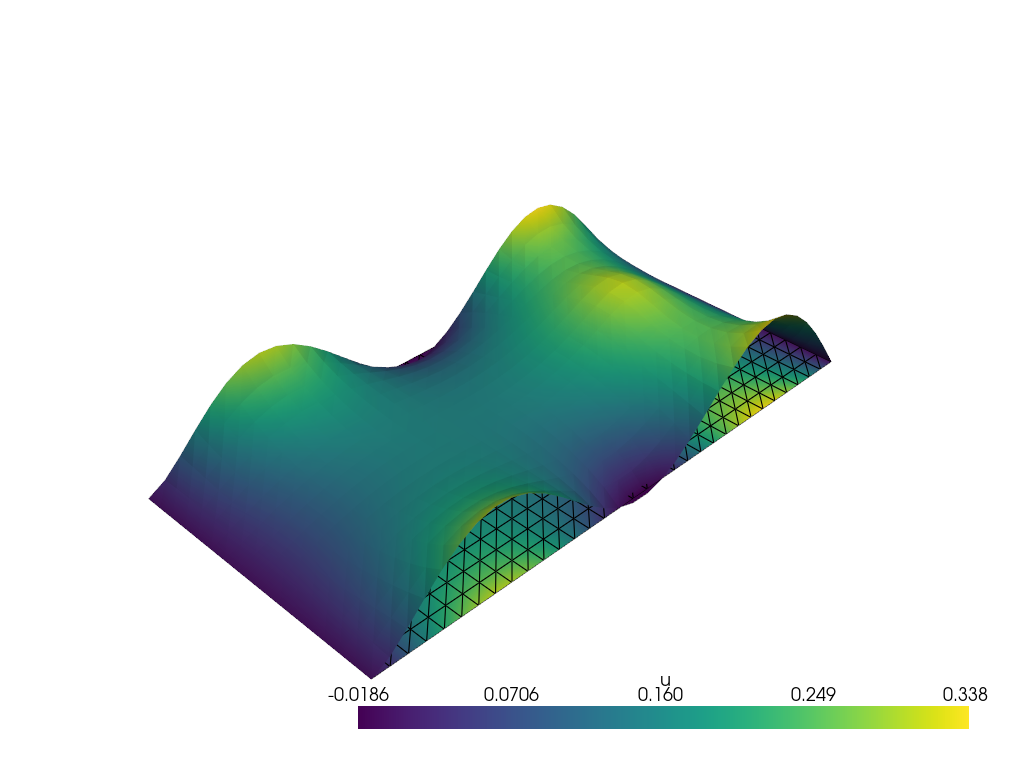

In [2]:
import importlib.util
if importlib.util.find_spec("petsc4py") is not None:
    import dolfinx
    if not dolfinx.has_petsc:
        exit(0)
    from petsc4py.PETSc import ScalarType
else:
    exit(0)

from mpi4py import MPI
import numpy as np
import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner

msh = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=((0.0, 0.0), (2.0, 1.0)),
    n=(32, 16),
    cell_type=mesh.CellType.triangle,
)
V = fem.functionspace(msh, ("Lagrange", 1))

facets = mesh.locate_entities_boundary(
    msh,
    dim=(msh.topology.dim - 1),
    marker=lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], 2.0),
)
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)
f = 10 * ufl.exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)
g = ufl.sin(5 * x[0])
a = inner(grad(u), grad(v)) * dx
L = inner(f, v) * dx + inner(g, v) * ds

problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

with io.XDMFFile(msh.comm, "out_poisson/poisson.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_function(uh)

try:
    import pyvista
    cells, types, X = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, X)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    p = pyvista.Plotter()
    p.add_mesh(grid, show_edges=True)
    p.add_mesh(grid.warp_by_scalar())
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        p.screenshot("uh_poisson.png")
    else:
        p.show()
except ModuleNotFoundError:
    pass


[poisson_legacy_dx] u in [-0.0732719, 0]


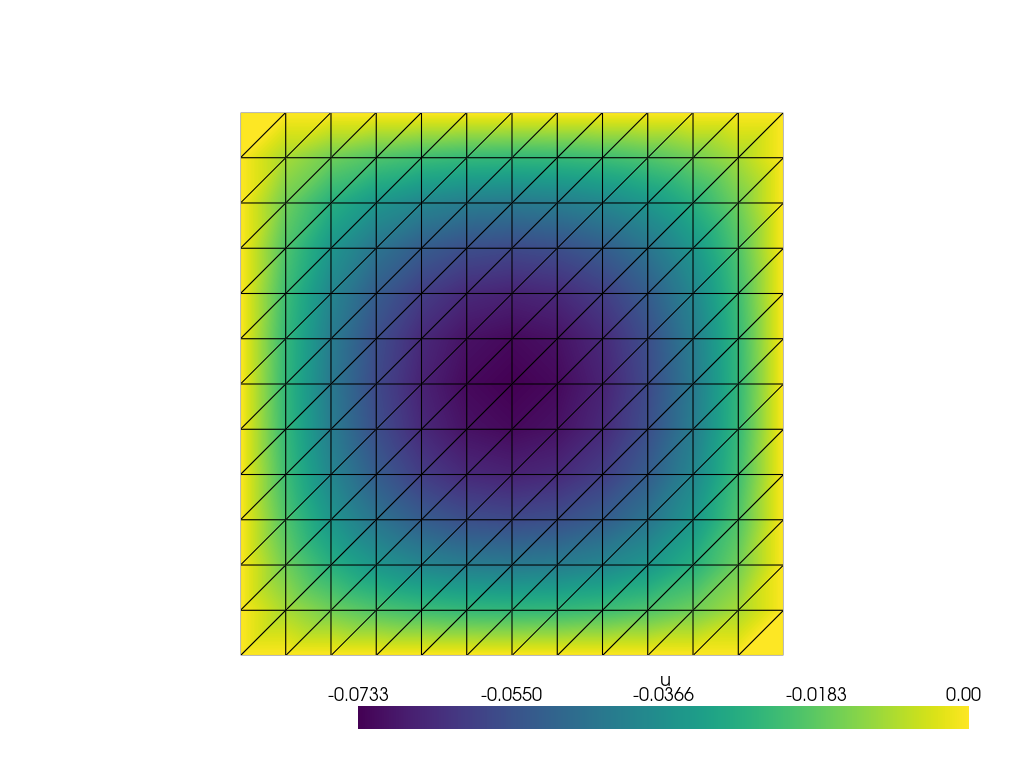

In [5]:
# poisson_legacy_dx.py
# FEniCSx/Dolfinx translation of the legacy Poisson example:
#   - Domain: unit square (0,1)x(0,1)
#   - PDE:    -Δu = f  with  u = 0 on ∂Ω
#   - RHS:    f = -1.0  (constant)
#
# Output: XDMF (relative paths) for easy ParaView loading via the .xdmf only.

import importlib.util
if importlib.util.find_spec("petsc4py") is None:
    raise SystemExit("petsc4py not found; install FEniCSx stack.")
import dolfinx
if not dolfinx.has_petsc:
    raise SystemExit("Dolfinx built without PETSc.")

from mpi4py import MPI
import numpy as np
import ufl
from dolfinx import mesh, fem, io
from dolfinx.fem.petsc import LinearProblem
from ufl import dx, grad, inner

# -----------------------
# Discretization settings
# -----------------------
N_POINTS_P_AXIS = 12  # matches legacy
FORCING_MAGNITUDE = 1.0

# ------
# Mesh
# ------
msh = mesh.create_unit_square(
    MPI.COMM_WORLD,
    N_POINTS_P_AXIS,
    N_POINTS_P_AXIS,
    cell_type=mesh.CellType.triangle,
)

# -----------------------
# Function space (CG1)
# -----------------------
V = fem.functionspace(msh, ("Lagrange", 1))

# -----------------------
# Boundary: u = 0 on all ∂Ω
# -----------------------
def on_boundary_all(x):
    return (
        np.isclose(x[0], 0.0) | np.isclose(x[0], 1.0) |
        np.isclose(x[1], 0.0) | np.isclose(x[1], 1.0)
    )

facets = mesh.locate_entities_boundary(
    msh, dim=msh.topology.dim - 1, marker=on_boundary_all
)
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

from petsc4py.PETSc import ScalarType
bc = fem.dirichletbc(value=ScalarType(0.0), dofs=dofs, V=V)

# -----------------------
# Variational problem
# -----------------------
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Legacy had: forcing = Constant(-FORCING_MAGNITUDE)
f = fem.Constant(msh, ScalarType(-FORCING_MAGNITUDE))

a = inner(grad(u), grad(v)) * dx
L = f * v * dx

problem = LinearProblem(
    a, L, bcs=[bc],
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        # Uncomment for MUMPS if available:
        # "pc_factor_mat_solver_type": "mumps",
    },
)
uh = problem.solve()

# -----------------------
# Output (XDMF + HDF5)
# -----------------------
outdir = "out_poisson_legacy"
from pathlib import Path
Path(outdir).mkdir(parents=True, exist_ok=True)

with io.XDMFFile(msh.comm, f"{outdir}/poisson_legacy.xdmf", "w") as xdmf:
    xdmf.write_mesh(msh)
    xdmf.write_function(uh)

# Optional: quick scalar range print (rank 0)
if msh.comm.rank == 0:
    umin = float(uh.x.array.min())
    umax = float(uh.x.array.max())
    print(f"[poisson_legacy_dx] u in [{umin:.6g}, {umax:.6g}]")

try:
    import pyvista
    from dolfinx import plot as dfxplot

    cells, types, X = dfxplot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, X)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")

    p = pyvista.Plotter()
    p.add_mesh(
        grid,
        show_edges=True,
        cmap="viridis",
        lighting=False,
    )
    p.view_xy()                    # ⟵ top-down 2D view
    p.enable_parallel_projection() # ⟵ remove perspective
    p.set_background("white")

    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        p.screenshot("uh_poisson_2d.png")
    else:
        p.show()
except ModuleNotFoundError:
    pass
